Building a 2-layer perceptron using the torch.nn module:

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [11]:
from torch.utils.data import TensorDataset, DataLoader

In [13]:
import torch.nn as nn

In [74]:
import matplotlib.pyplot as plt

In [2]:
iris = load_iris()

In [3]:
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1./3, random_state=1)

Here, we randomly select 100 samples (2/3) for training and 50 samples (1/3) for testing. 

Next, we standardize the features (mean centering and dividing by the standard deviation) and create a PyTorch Dataset for the traininf set and a corresponding dataloader

In [4]:
X_train.shape

(100, 4)

In [12]:
X_train_norm = (X_train - np.mean(X_train, axis=0))/np.std(X_train, axis=0)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm,y_train)

torch.manual_seed(1)

batch_size = 2

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Next, we're ready to use the torch.nn module to build a model efficiently. 

In [67]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

In [68]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size)

In [69]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

Now, we can train the model: We will specify the number of epochs to be 100. The code for training the flower classification model is now as follows:

In [73]:
num_epochs = 100
loss_hist = [0]*num_epochs
accuracy_hist = [0]*num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        y_batch = y_batch.to(torch.int64)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

The loss_hist and accuracy_hist keep the training loss and training accuracy after each epoch: we can use this to visualize the learning curves as follows:

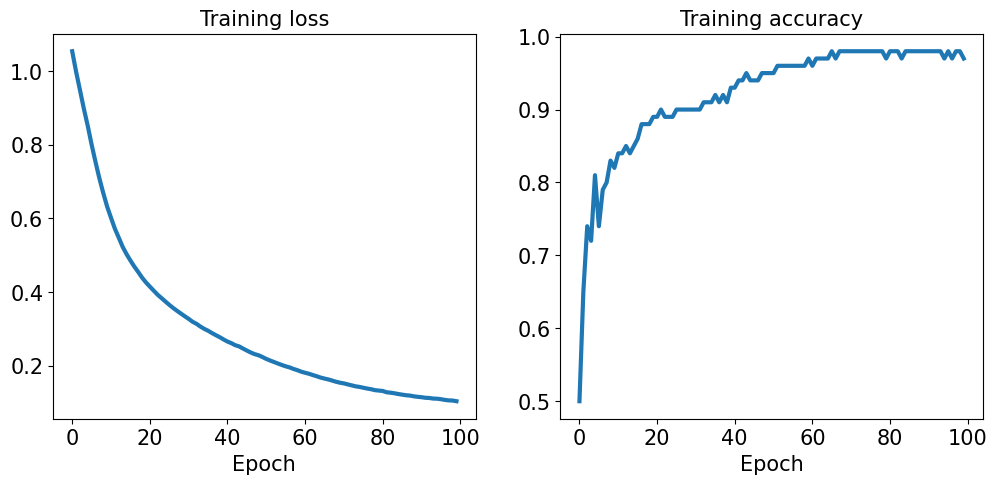

In [75]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(loss_hist, lw=3)
ax[0].set_title('Training loss', size=15)
ax[0].set_xlabel('Epoch', size=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].plot(accuracy_hist, lw=3)
ax[1].set_title('Training accuracy', size=15)
ax[1].set_xlabel('Epoch', size=15)
ax[1].tick_params(axis='both',which='major',labelsize=15)
plt.show()

In [77]:
loss_hist[:10], loss_hist[90:]

([1.053402796983719,
  0.9982022607326507,
  0.9482276582717896,
  0.8977269279956818,
  0.8514285576343537,
  0.8003995680809021,
  0.753425406217575,
  0.7089984560012818,
  0.6689576029777526,
  0.632134634256363],
 [0.11504975682124495,
  0.11348246438428759,
  0.11292662329971791,
  0.11134741706773639,
  0.11099112264811993,
  0.10965341346338392,
  0.1076933486200869,
  0.10641433000564575,
  0.10597399082034827,
  0.1041590704023838])

In [79]:
accuracy_hist[:10], accuracy_hist[90:]

([tensor(0.5000),
  tensor(0.6500),
  tensor(0.7400),
  tensor(0.7200),
  tensor(0.8100),
  tensor(0.7400),
  tensor(0.7900),
  tensor(0.8000),
  tensor(0.8300),
  tensor(0.8200)],
 [tensor(0.9800),
  tensor(0.9800),
  tensor(0.9800),
  tensor(0.9800),
  tensor(0.9700),
  tensor(0.9800),
  tensor(0.9700),
  tensor(0.9800),
  tensor(0.9800),
  tensor(0.9700)])

Evaluating the trained model on the test dataset:

We can now evaluate the classification accuracy of the trained model on the test dataset:

In [81]:
X_test_norm = (X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test).long()

In [82]:
pred_test = model(X_test_norm)

In [83]:
correct = (torch.argmax(pred_test, dim=1)==y_test).float()

In [85]:
accuracy = correct.mean()
print(f'Test Acc: {accuracy:.4f}')

Test Acc: 0.9600


**Savinf and reloading the trained model:**
Trained models can be saved on disk for future use. This can be done as follows:

In [87]:
path = "C:/Users/blais/Documents/ML/data/models/iris_classifier.pt"
torch.save(model, path)

Calling save(model) will save both the model architecture and all learned parameters. As a common convention, we can save models using a pt or pth file extension.

Now - lets reload the sav

When it comes to saving and loading models - 3 core functions to be familiar with:
- torch.save: saves a serialized object to disk. Uses python's pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using the torch.save function
- torch.load: Uses pickle's unpickling facilities to deserialize pickled object files to memory. also facilitates the device to load the data in

**What is a state_dict?**
- In PyTorch - the learnable parameters (weights and biases) of a torch.nn.Module model are contained in the model's parameters - which are accessed with model.parameters(). A state_dict is simply a python dictionary object that maps each layer to its param tensor. Note that only layers with learnable parameters (conv layers, linear layers, etc) and registered buffers (batchnorm's, running_mean) have entries in the model's state_dict. Optimizer objects (torch.optim) also have a state_dict, with info on the optimizer's state as well as the hyperparameters used.

- Because state dict objects are python dictionaries - they can be easily saved, updatedd, altered and restored - adding a great deal of modularity to pytorch models and optimizers.

Let's take a look at the state dict from our model:

In [89]:
# print the model's state dict:
print("Model's state dict: ")
for param_tensor in model.state_dict():
    print(param_tensor,"\t",model.state_dict()[param_tensor].size())

# print the optimizer's state dict:
print("Optimizer's state dict:")
for var_name in optimizer.state_dict():
    print(var_name,"\t",optimizer.state_dict()[var_name])

Model's state dict: 
layer1.weight 	 torch.Size([16, 4])
layer1.bias 	 torch.Size([16])
layer2.weight 	 torch.Size([3, 16])
layer2.bias 	 torch.Size([3])
Optimizer's state dict:
state 	 {0: {'step': tensor(5000.), 'exp_avg': tensor([[ 4.5491e-04, -2.6386e-03,  1.4238e-03,  3.4213e-04],
        [-5.9700e-05, -5.8832e-04,  2.1251e-04,  1.7576e-04],
        [ 1.5216e-04,  9.0394e-04,  1.7351e-05,  1.0837e-04],
        [-1.1444e-04,  1.6847e-03, -2.3645e-04,  2.8990e-04],
        [ 1.8378e-04, -7.8801e-04,  5.5868e-05, -2.0333e-04],
        [ 1.7413e-03, -1.7697e-03,  1.5525e-03,  7.3923e-05],
        [ 2.2575e-03, -3.8488e-03,  3.2041e-03,  9.0981e-04],
        [-4.8311e-04,  1.2882e-03, -6.1595e-04, -2.0266e-05],
        [ 1.7702e-04, -1.1870e-03, -1.7370e-04, -5.6690e-04],
        [ 7.0788e-05,  7.6622e-04, -4.7721e-04, -4.5581e-04],
        [ 1.3855e-03, -1.9070e-03,  1.3340e-03, -6.4605e-05],
        [ 1.0068e-03, -2.4781e-03,  2.2774e-03,  1.0922e-03],
        [ 7.6686e-06,  8.6624e-

saving and loading model for inference:

In [ ]:
# saving:
# 